<a href="https://colab.research.google.com/github/dangdang2222/skt_ai_fellowship/blob/main/cmapss_viz_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Lambda, LSTM, RepeatVector,Bidirectional, Masking, Dropout

------------------------unils.py-------------------

In [2]:
import math
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard, LambdaCallback

In [3]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

In [4]:
def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['setting_1'] = abs(df_op_cond['setting_1'].round())
    df_op_cond['setting_2'] = abs(df_op_cond['setting_2'].round(decimals=2))
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)
    
    return df_op_cond


In [5]:
def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

In [6]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, take the exponential weighted mean
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean()).reset_index(level=0, drop=True)
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

In [7]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

In [8]:
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array


In [9]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

In [10]:
def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array


In [11]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]  

In [12]:
def get_data(dataset, sensors, sequence_length, alpha, threshold):
	# files
	dir_path = './drive/MyDrive/CMaps/'
	train_file = 'train_'+dataset+'.txt'
	test_file = 'test_'+dataset+'.txt'
    # columns
	index_names = ['unit_nr', 'time_cycles']
	setting_names = ['setting_1', 'setting_2', 'setting_3']
	sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
	col_names = index_names + setting_names + sensor_names
    # data readout
	train = pd.read_csv((dir_path+train_file), sep=r'\s+', header=None, 
					 names=col_names)
	test = pd.read_csv((dir_path+test_file), sep=r'\s+', header=None, 
					 names=col_names)
	y_test = pd.read_csv((dir_path+'RUL_'+dataset+'.txt'), sep=r'\s+', header=None, 
					 names=['RemainingUsefulLife'])

    # create RUL values according to the piece-wise target function
	train = add_remaining_useful_life(train)
	train['RUL'].clip(upper=threshold, inplace=True)

    # remove unused sensors
	drop_sensors = [element for element in sensor_names if element not in sensors]

    # scale with respect to the operating condition
	X_train_pre = add_operating_condition(train.drop(drop_sensors, axis=1))
	X_test_pre = add_operating_condition(test.drop(drop_sensors, axis=1))
	X_train_pre, X_test_pre = condition_scaler(X_train_pre, X_test_pre, sensors);print("1")

    # exponential smoothing
	X_train_pre= exponential_smoothing(X_train_pre, sensors, 0, alpha)
	X_test_pre = exponential_smoothing(X_test_pre, sensors, 0, alpha)

	# train-val split
	gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
	# generate the train/val for *each* sample -> for that we iterate over the train and val units we want
	# this is a for that iterates only once and in that iterations at the same time iterates over all the values we want,
	# i.e. train_unit and val_unit are not a single value but a set of training/vali units
	for train_unit, val_unit in gss.split(X_train_pre['unit_nr'].unique(), groups=X_train_pre['unit_nr'].unique()): 
		train_unit = X_train_pre['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
		val_unit = X_train_pre['unit_nr'].unique()[val_unit]

		x_train = gen_data_wrapper(X_train_pre, sequence_length, sensors, train_unit)
		y_train = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], train_unit)
		
		x_val = gen_data_wrapper(X_train_pre, sequence_length, sensors, val_unit)
		y_val = gen_label_wrapper(X_train_pre, sequence_length, ['RUL'], val_unit)

	# create sequences for test 
	test_gen = (list(gen_test_data(X_test_pre[X_test_pre['unit_nr']==unit_nr], sequence_length, sensors, -99.))
			   for unit_nr in X_test_pre['unit_nr'].unique())
	x_test = np.concatenate(list(test_gen)).astype(np.float32)
	
	return x_train, y_train, x_val, y_val, x_test, y_test['RemainingUsefulLife']

In [13]:
class save_latent_space_viz(Callback):
	def __init__(self, model, data, target):
		self.model = model
		self.data = data
		self.target = target
	
	def on_train_begin(self, logs={}):
		self.best_val_loss = 100000
		
	def on_epoch_end(self, epoch, logs=None):
		encoder = self.model.layers[0]
		if logs.get('val_loss') < self.best_val_loss:
			self.best_val_loss = logs.get('val_loss')
			viz_latent_space(encoder, self.data, self.target, epoch, True, False)
	

In [14]:
def get_callbacks(model, data, target):
	model_callbacks = [
		EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30),
        ModelCheckpoint(filepath='./checkpoints/checkpoint',monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True),
		TensorBoard(log_dir='./logs'),
        save_latent_space_viz(model, data, target)
	]
	return model_callbacks


In [15]:
def viz_latent_space(encoder, data, targets=[], epoch='Final', save=False, show=True):
    z, _, _  = encoder.predict(data)
    plt.figure(figsize=(8, 10))
    if len(targets)>0:
        plt.scatter(z[:, 0], z[:, 1], c=targets)
    else:
        plt.scatter(z[:, 0], z[:, 1])
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    if show:
        plt.show();print("aaaaare we in?")
    if save:
        plt.savefig('./latent_space_epoch'+str(epoch)+'.png');print("aaaaare we in?")
    return z

In [16]:
class LRFinder:
    """
    Cyclical LR, code tailored from:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

In [17]:
def get_model(path):
    saved_VRAE_model = load_model(path, compile=False)
    
    # return encoder, regressor
    return saved_VRAE_model.layers[1], saved_VRAE_model.layers[2]

In [18]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [19]:
def score(y_true, y_hat):
  res = 0
  for true, hat in zip(y_true, y_hat):
    subs = hat - true
    if subs < 0:
      res = res + np.exp(-subs/13)[0]-1
    else:
      res = res + np.exp(subs/10)[0]-1
  print("score: ", res)

In [20]:
def results(path, x_train, y_train, x_test, y_test):
    # Get model
    encoder, regressor = get_model(path)
    # Latent space
    train_mu = viz_latent_space(encoder, x_train, y_train)
    test_mu = viz_latent_space(encoder, x_test, y_test)
    # Evaluate
    y_hat_train = regressor.predict(train_mu)
    y_hat_test = regressor.predict(test_mu)

    evaluate(y_train, y_hat_train, 'train')
    evaluate(y_test, y_hat_test, 'test')
    score(y_test, y_hat_test)

In [21]:
dataset = "FD001"
	# sensors to work with: T30, T50, P30, PS30, phi
sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_11', 's_12', 's_13', 's_15', 's_17', 's_20', 's_21']
	# windows length
sequence_length = 30
	# smoothing intensity
alpha = 0.1
	# max RUL
threshold = 125
	
x_train, y_train, x_val, y_val, x_test, y_test = get_data(dataset, sensors, 
	sequence_length, alpha, threshold)

1


----------------------data-------------------------

In [22]:
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Masking

# keeping the random seed constant from one experiment to the next makes it 
# easier to interpret the effects of hyper-parameters values 
seed = 99
random.seed(seed)
tf.random.set_seed(seed)

def create_model(timesteps, input_dim, intermediate_dim, batch_size, latent_dim, epochs, optimizer):
	# Setup the network parameters:
	timesteps = timesteps
	input_dim = input_dim
	intermediate_dim = intermediate_dim
	batch_size = batch_size
	latent_dim = latent_dim
	epochs = epochs
	if optimizer == 'adam':
		optimizer = keras.optimizers.Adam(learning_rate=0.0001)
	else:
		print("unimplemented optimizer")
		exit(-1)
	masking_value = -99.

	class Sampling(keras.layers.Layer):
		"""Uses (z_mean, sigma) to sample z, the vector encoding an engine trajetory."""
		def call(self, inputs):
			mu, sigma = inputs
			batch = tf.shape(mu)[0]
			dim = tf.shape(mu)[1]
			epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
			return mu + tf.exp(0.5 * sigma) * epsilon
	
	# ----------------------- Encoder -----------------------
	inputs = Input(shape=(timesteps, input_dim,), name='encoder_input')

	mask = Masking(mask_value=masking_value)(inputs)
	
	# LSTM encoding
	h = Bidirectional(LSTM(intermediate_dim))(mask) 

	# VAE Z layer
	mu = Dense(latent_dim)(h)
	sigma = Dense(latent_dim)(h)

	z = Sampling()([mu, sigma])

	# Instantiate the encoder model:
	encoder = keras.Model(inputs, [z, mu, sigma], name='encoder')
	print(encoder.summary())
	# -------------------------------------------------------
	
	# ----------------------- Regressor --------------------
	reg_latent_inputs = Input(shape=(latent_dim,), name='z_sampling_reg')
	reg_intermediate = Dense(200, activation='tanh')(reg_latent_inputs)
	reg_outputs = Dense(1, name='reg_output')(reg_intermediate)
	# Instantiate the classifier model:
	regressor = keras.Model(reg_latent_inputs, reg_outputs, name='regressor')
	print(regressor.summary())
	# -------------------------------------------------------

	''' uncomment if needed
	# ----------------------- Decoder --------------------
	latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
	h_decoded = RepeatVector(timesteps)(latent_inputs)
	h_decoded = Bidirectional(LSTM(intermediate_dim, return_sequences=True))(h_decoded) 
	# decoded layer
	outputs = LSTM(input_dim, return_sequences=True)(h_decoded) 
	# Instantiate the decoder model:
	decoder = keras.Model(latent_inputs, outputs, name='decoder')
	print(decoder.summary())
	# -------------------------------------------------------
	'''
	
	# -------------------- Wrapper model --------------------
	class RVE(keras.Model):
		def __init__(self, encoder, regressor, decoder=None, **kwargs):
			super(RVE, self).__init__(**kwargs)
			self.encoder = encoder
			self.regressor = regressor
			self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
			self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
			self.reg_loss_tracker = keras.metrics.Mean(name="reg_loss")
			self.decoder = decoder
			if self.decoder!=None:
				self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
			

		@property
		def metrics(self):
			if self.decoder!=None:
				return [
					self.total_loss_tracker,
					self.kl_loss_tracker,
					self.reg_loss_tracker,
					self.reconstruction_loss_tracker
				]
			else:
				return [
					self.total_loss_tracker,
					self.kl_loss_tracker,
					self.reg_loss_tracker,
				]

		def train_step(self, data):
			x, target_x = data
			with tf.GradientTape() as tape:
				# kl loss
				z, mu, sigma = self.encoder(x)
				kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
				kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
				# Regressor
				reg_prediction = self.regressor(z)
				reg_loss = tf.reduce_mean(
					keras.losses.mse(target_x, reg_prediction)
				)
				# Reconstruction
				if self.decoder!=None:
					reconstruction = self.decoder(z)
					reconstruction_loss = tf.reduce_mean(
						keras.losses.mse(x, reconstruction)
					)
					total_loss = kl_loss + reg_loss + reconstruction_loss
					self.reconstruction_loss_tracker.update_state(reconstruction_loss)
				else:
					total_loss = kl_loss + reg_loss
			grads = tape.gradient(total_loss, self.trainable_weights)
			self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
			self.total_loss_tracker.update_state(total_loss)
			self.kl_loss_tracker.update_state(kl_loss)
			self.reg_loss_tracker.update_state(reg_loss)
			return {
				"loss": self.total_loss_tracker.result(),
				"kl_loss": self.kl_loss_tracker.result(),
				"reg_loss": self.reg_loss_tracker.result(),
			}


		def test_step(self, data):
			x, target_x = data

			# kl loss
			z, mu, sigma = self.encoder(x)
			kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
			kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
			# Regressor
			reg_prediction = self.regressor(z)
			reg_loss = tf.reduce_mean(
				keras.losses.mse(target_x, reg_prediction)
			)
			# Reconstruction
			if self.decoder!=None:
				reconstruction = self.decoder(z)
				reconstruction_loss = tf.reduce_mean(
					keras.losses.mse(x, reconstruction)
				)
				total_loss = kl_loss + reg_loss + reconstruction_loss
			else:
				total_loss = kl_loss + reg_loss

			return {
				"loss": total_loss,
				"kl_loss": kl_loss,
				"reg_loss": reg_loss,
			}
	# -------------------------------------------------------

	rve = RVE(encoder, regressor)
	rve.compile(optimizer=optimizer, metrics=["accuracy"])

	return rve

In [23]:
timesteps = x_train.shape[1]
input_dim = x_train.shape[2]
intermediate_dim = 300
batch_size = 128
latent_dim = 2
epochs = 10000
optimizer = 'adam'

In [24]:
RVE = create_model(timesteps, 
		input_dim, 
		intermediate_dim, 
		batch_size, 
		latent_dim, 
		epochs, 
		optimizer,
		)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 30, 12)]     0           []                               
                                                                                                  
 masking (Masking)              (None, 30, 12)       0           ['encoder_input[0][0]']          
                                                                                                  
 bidirectional (Bidirectional)  (None, 600)          751200      ['masking[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 2)            1202        ['bidirectional[0][0]']          
                                                                                            

In [25]:
model_callbacks = get_callbacks(RVE, x_train, y_train)

Epoch 1/10000

Epoch 1: val_loss improved from inf to 257.11618, saving model to ./checkpoints/checkpoint
aaaaare we in?
112/112 - 30s - loss: 7749.6963 - kl_loss: 73.4289 - reg_loss: 7676.2656 - val_loss: 257.1162 - val_kl_loss: 70.7773 - val_reg_loss: 186.3389 - 30s/epoch - 266ms/step
Epoch 2/10000

Epoch 2: val_loss improved from 257.11618 to 188.38197, saving model to ./checkpoints/checkpoint
aaaaare we in?
112/112 - 4s - loss: 6901.1494 - kl_loss: 166.4087 - reg_loss: 6734.7393 - val_loss: 188.3820 - val_kl_loss: 54.2360 - val_reg_loss: 134.1459 - 4s/epoch - 36ms/step
Epoch 3/10000

Epoch 3: val_loss improved from 188.38197 to 129.73048, saving model to ./checkpoints/checkpoint
aaaaare we in?
112/112 - 4s - loss: 6385.4194 - kl_loss: 174.8683 - reg_loss: 6210.5518 - val_loss: 129.7305 - val_kl_loss: 38.8916 - val_reg_loss: 90.8389 - 4s/epoch - 35ms/step
Epoch 4/10000

Epoch 4: val_loss improved from 129.73048 to 90.47771, saving model to ./checkpoints/checkpoint
aaaaare we in?
112

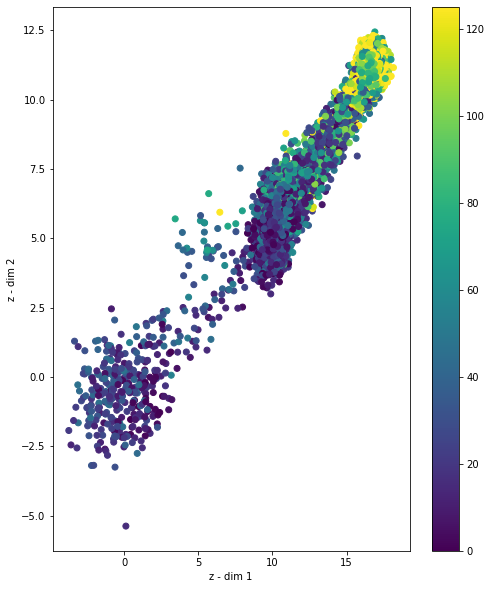

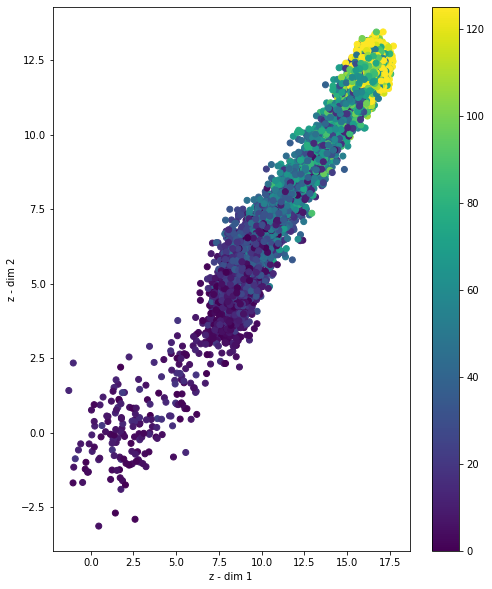

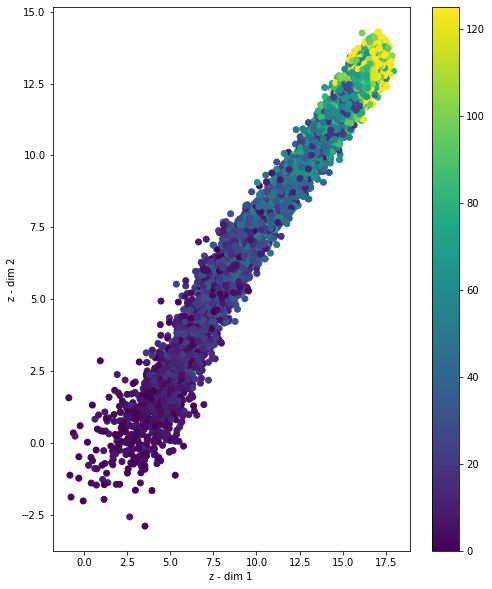

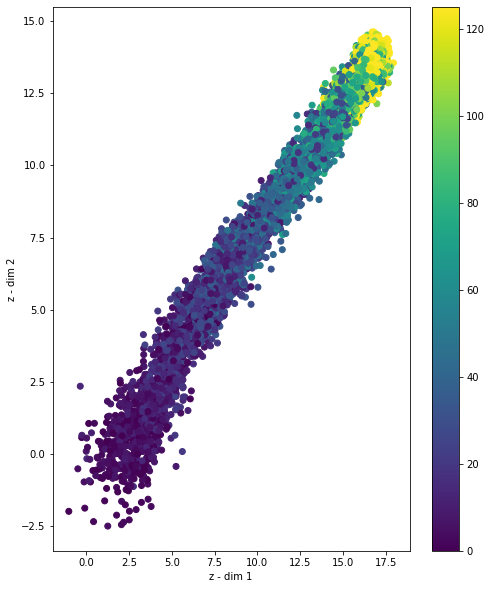

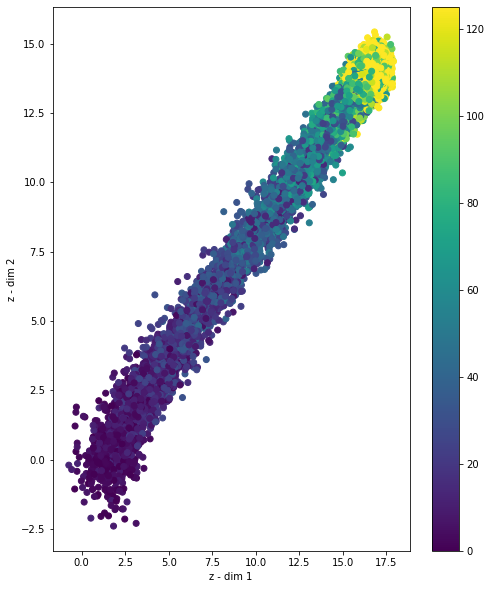

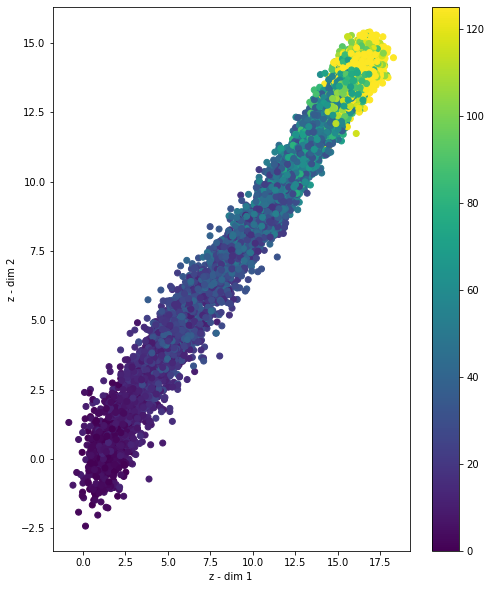

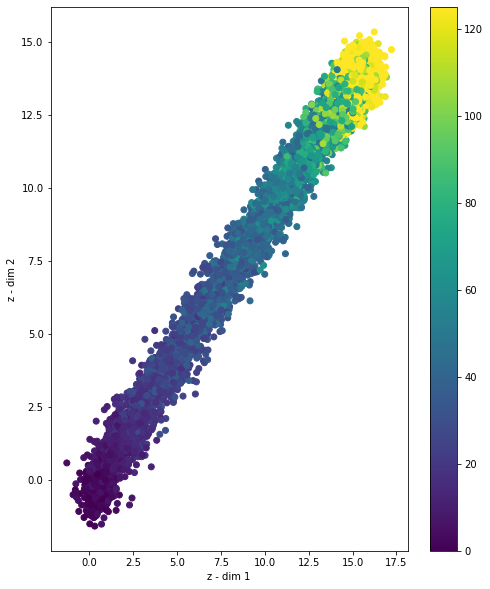

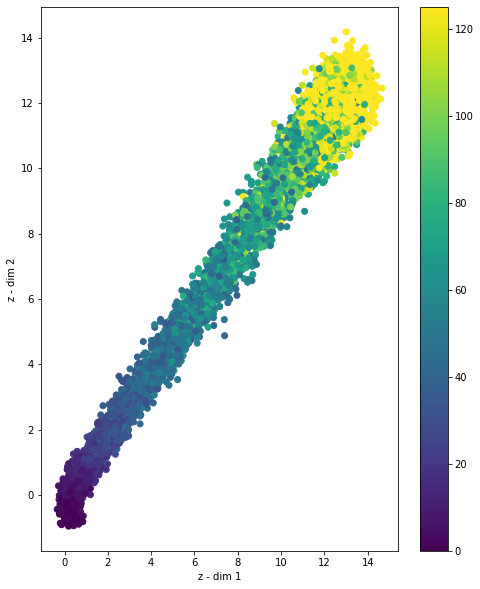

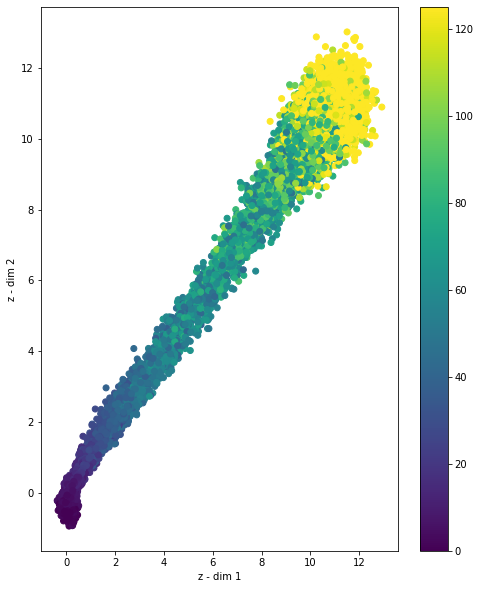

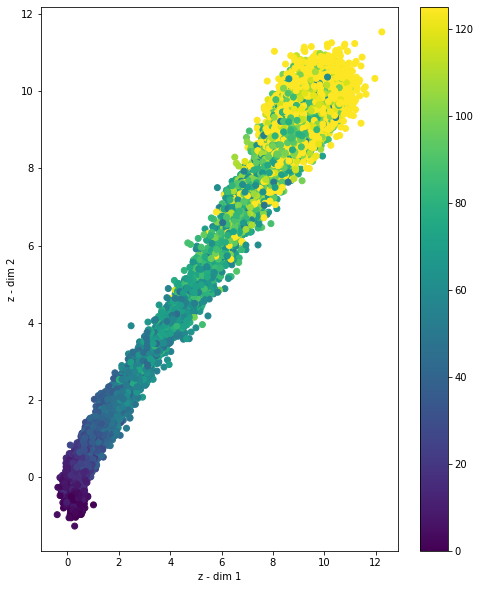

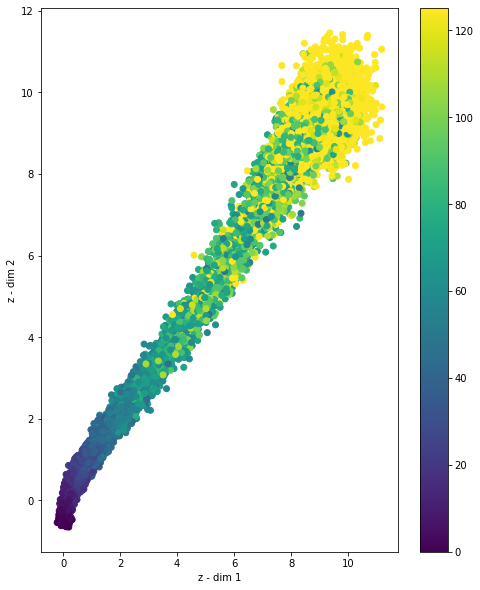

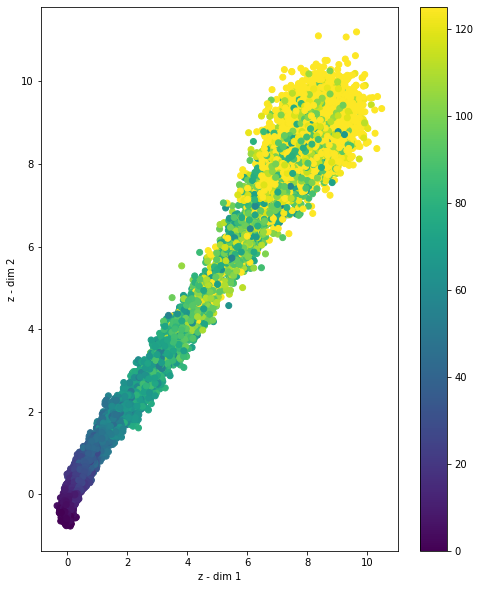

In [26]:
results = RVE.fit(x_train, y_train,
			shuffle=True,
			epochs=epochs,
			batch_size=batch_size,
			validation_data= (x_val, y_val),
			callbacks=model_callbacks, verbose=2)

In [27]:
!pwd

/content


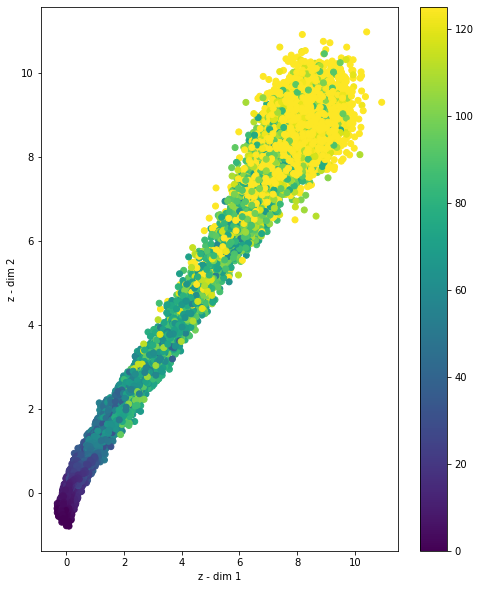

aaaaare we in?


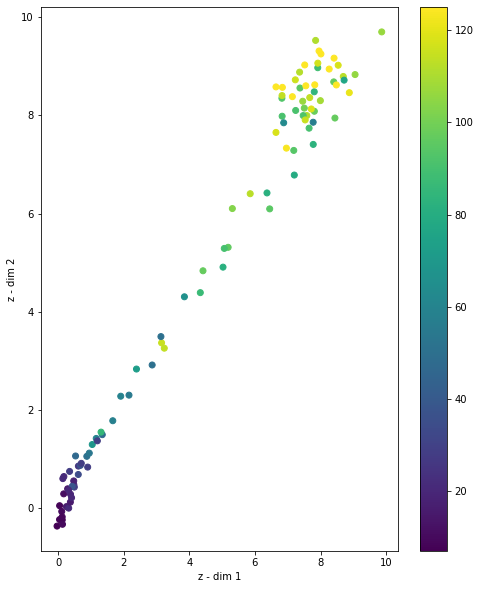

aaaaare we in?
train set RMSE:25.235193252563477, R2:0.6355304292924208
test set RMSE:23.81803941561975, R2:0.6714870644523383


In [28]:
RVE.load_weights('./checkpoints/checkpoint')
train_mu = viz_latent_space(RVE.encoder, np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))
test_mu = viz_latent_space(RVE.encoder, x_test, y_test.clip(upper=threshold))
	# Evaluate
y_hat_train = RVE.regressor.predict(train_mu)
y_hat_test = RVE.regressor.predict(test_mu)

evaluate(np.concatenate((y_train, y_val)), y_hat_train, 'train')
evaluate(y_test, y_hat_test, 'test')

In [29]:
y_actual = y_test.tolist()
y_pred=y_hat_test.tolist()

In [30]:
index=[]
for i in range (len(y_actual)):
    index.append(i)

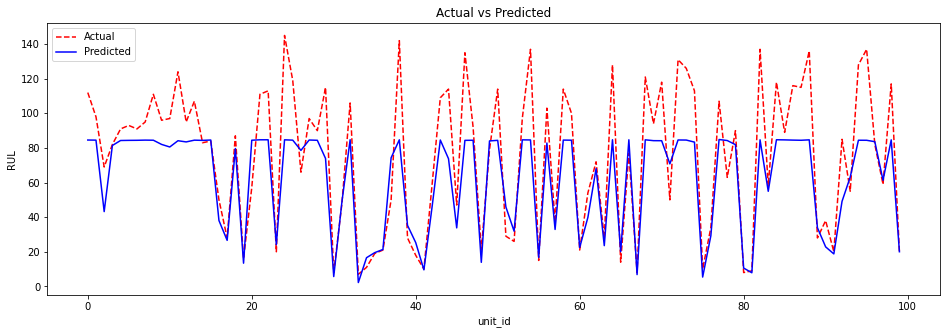

In [31]:
plt.figure(figsize=(16,5))

plt.plot(index,y_actual,color='red',linestyle='dashed')

plt.plot(index,y_pred,color='blue')

plt.ylabel('RUL')

plt.xlabel('unit_id')

plt.title('Actual vs Predicted')

plt.legend(['Actual','Predicted'])


In [32]:
RVE.history.params

{'epochs': 10000, 'steps': 112, 'verbose': 2}

In [33]:
print(RVE.history)

In [34]:
results.history.keys()

dict_keys(['loss', 'kl_loss', 'reg_loss', 'val_loss', 'val_kl_loss', 'val_reg_loss'])

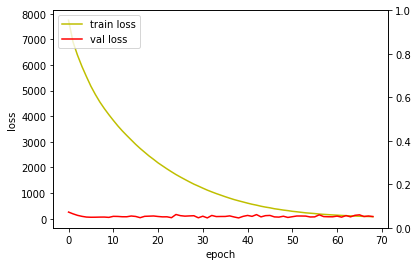

In [35]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()

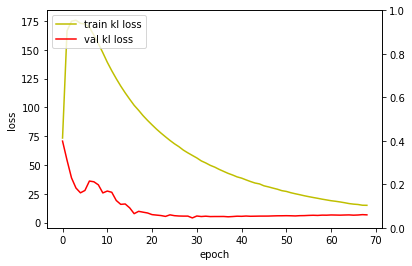

In [36]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['kl_loss'], 'y', label='train kl loss')
loss_ax.plot(results.history['val_kl_loss'], 'r', label='val kl loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()

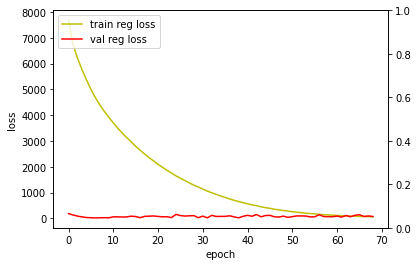

In [37]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['reg_loss'], 'y', label='train reg loss')
loss_ax.plot(results.history['val_reg_loss'], 'r', label='val reg loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()

accuracy가 보고싶으면 RVE 모델 올라가서 metrics, track step에 직접 넣어야함